In [1]:
# load the package
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import sklearn.metrics as metrics
from subprocess import call
from IPython.display import Image
from sklearn.model_selection import KFold #cross validation

# Data exploration

In [2]:
# read the data
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


12 features with 5 catogrical features, some features contain the missing data

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric
- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names
- we can drop PassengerId as it shows as index
- Ticket feature may be dropped as Ticket feature is too noisy to be useful and there may not be a correlation between Ticket and survival, as logistically, it is generated randomly, also we have the feature of Pclass
- Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Max age is 80, which is reasonable, but still need to check the outlier
- 38% average survival rate

In [6]:
# variables in each feature
for column in train[['Survived','Pclass','Age','SibSp','Parch','Fare']]:
    uniques = sorted(train[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

Survived                 2	 [0, 1]
Pclass                   3	 [1, 2, 3]
Age                     89	 [0.83, 2.0, 3.0, 4.0, 5.0]
SibSp                    7	 [0, 1, 2, 3, 4]
Parch                    7	 [0, 1, 2, 3, 4]
Fare                   248	 [0.0, 4.0125, 5.0, 6.2375, 6.4375]


- We can drip cabin, as it contains more than 50% missing value in both test and train dataset
- Age and Embarked have missing value, need to fill in value later

**Handling outlier**

In [7]:
# outlier detection [Tukey method]
from collections import Counter
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
   # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [8]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
# show the outliers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Training data has 10 outlier with either extreme fare or high amount of SibSp

In [9]:
# Drop outliers
train1=train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [10]:
# Check for test dataset
Outliers_to_drop = detect_outliers(test,2,["Age","SibSp","Parch","Fare"]) 
test.loc[Outliers_to_drop] 
test1=test.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

No outlier spotted in the test dataset

**Joining train and test set**

Join train and test datasets in order to obtain the same number of features during feature engineering

In [11]:
train_len = len(train) # for differentiate between train and test dataset later
dataset =  pd.concat([train, test])

**check for null and missing values**

In [12]:
# Fill empty and NaNs values with NaN
dataset=dataset.fillna(np.nan)
# Check for Null values
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Survived column doesn't exist in test set and has been replace by NaN values when concatenating dateset

In [13]:
# checking missing data
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (100*(df.isnull().sum())/(df.isnull().count())).sort_values(ascending=False)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        return(output)
    else:
        return(False)

In [14]:
check_missing_data(dataset)

,Total,Percent
Age,263,20.091673
Cabin,1014,77.463713
Embarked,2,0.152788
Fare,1,0.076394
Name,0,0.000000
Parch,0,0.000000
PassengerId,0,0.000000
Pclass,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000


# Feature Analysis

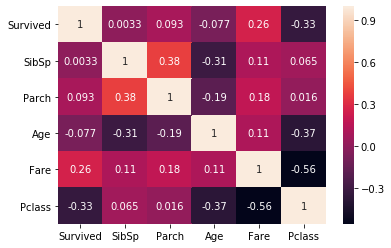

In [15]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
sns.heatmap(train1[["Survived","SibSp","Parch","Age","Fare",'Pclass']].corr(),annot=True)

**Feature: Age**

Age has 20% missing values

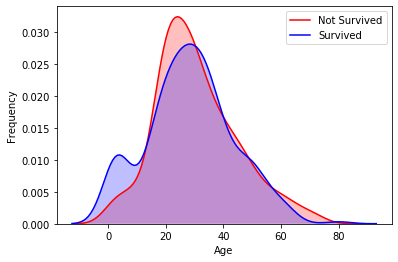

In [16]:
g = sns.kdeplot(train1['Age'][(train1['Survived'] == 0) & (train1['Age'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train1['Age'][(train1['Survived'] == 1) & (train1['Age'].notnull())], color="Blue", shade= True)
g.set_xlabel('Age')
g.set_ylabel("Frequency")
g = g.legend(['Not Survived','Survived'])

- Age seems follow a normal distribution
- Infant have more chance to survive
- There is age categories of passengers that of have more or less chance to survive.

**Feature: Pclass**

Text(0, 0.5, 'Average Survived Rate')

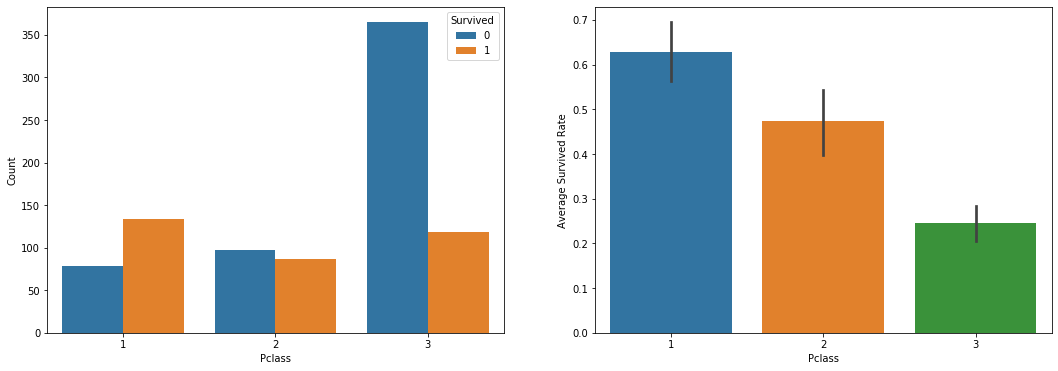

In [17]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
g=sns.countplot(x='Pclass',hue='Survived',data=train1,ax=ax[0])
g.set_ylabel('Count')
g= sns.barplot(x='Pclass',y='Survived',data=train1,ax=ax[1])
g.set_ylabel('Average Survived Rate')

- Pclass 1 has higher survived rate, Pclass can be used for model training
- Pclass has most passangers but lowest survived rate

**Feature: Sex**

Text(0, 0.5, 'Average Survived Rate')

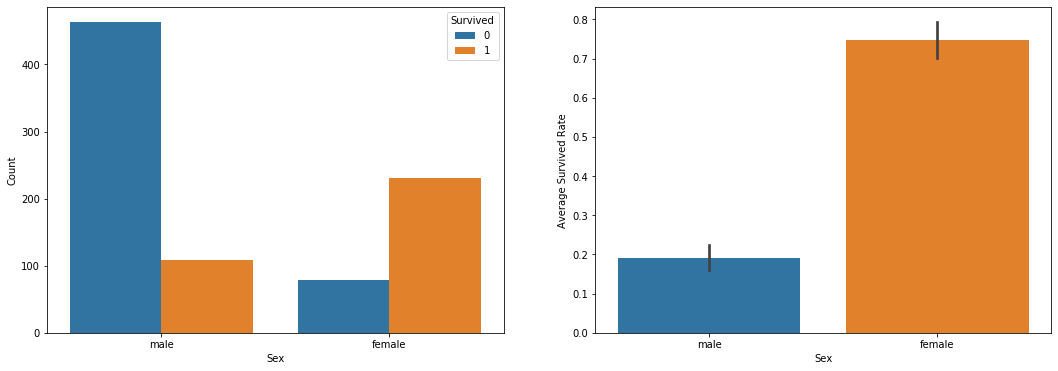

In [18]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
g=sns.countplot(x='Sex',hue='Survived',data=train1,ax=ax[0])
g.set_ylabel('Count')
g= sns.barplot(x='Sex',y='Survived',data=train1,ax=ax[1])
g.set_ylabel('Average Survived Rate')

Female has much higher survived rate than Male

**Feature: Embarked**

Embarked has two missing values

Text(0, 0.5, 'Average Survived Rate')

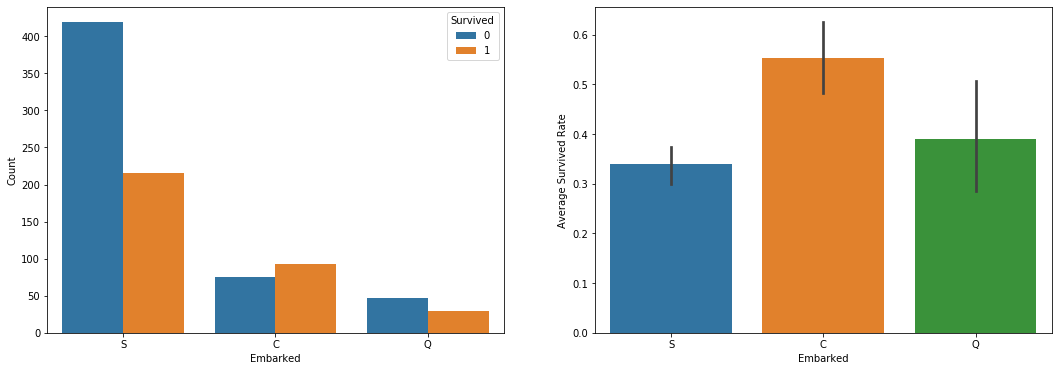

In [19]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
g=sns.countplot(x='Embarked',hue='Survived',data=train1,ax=ax[0])
g.set_ylabel('Count')
g= sns.barplot(x='Embarked',y='Survived',data=train1,ax=ax[1])
g.set_ylabel('Average Survived Rate')

**Feature: SibSp, Parch**

Text(0, 0.5, 'Average Survived Rate')

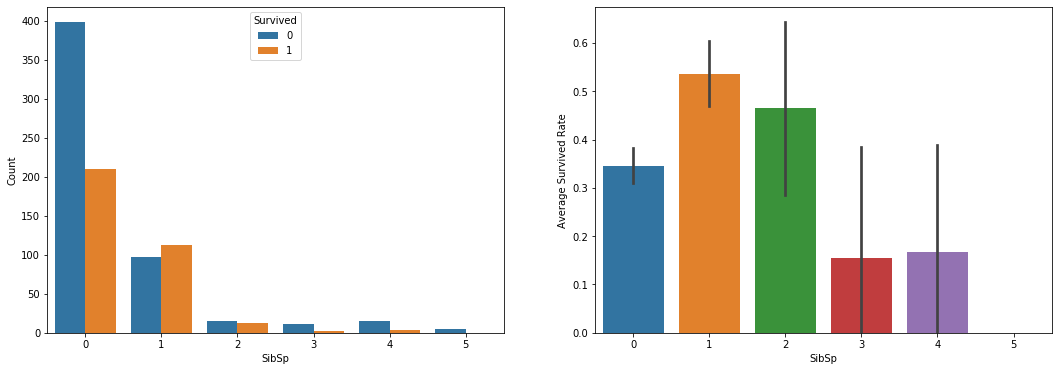

In [20]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
g=sns.countplot(x='SibSp',hue='Survived',data=train1,ax=ax[0])
g.set_ylabel('Count')
g= sns.barplot(x='SibSp',y='Survived',data=train1,ax=ax[1])
g.set_ylabel('Average Survived Rate')

Text(0, 0.5, 'Average Survived Rate')

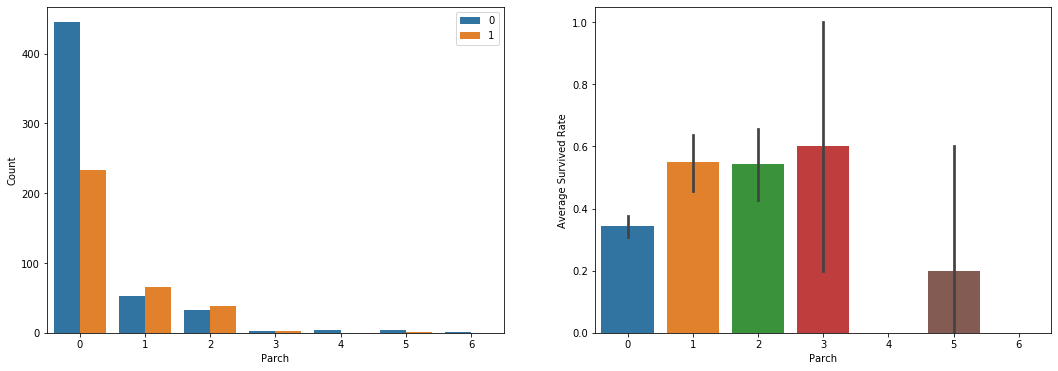

In [21]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(18,6))
g=sns.countplot(x='Parch',hue='Survived',data=train1,ax=ax[0])
g.set_ylabel('Count')
g=g.legend(loc='upper right')
g= sns.barplot(x='Parch',y='Survived',data=train1,ax=ax[1])
g.set_ylabel('Average Survived Rate')

# Feature Engineering

**1. missing value**

missing column: Age, Cabin, Embarked, Fare ( I will drop Cabin, as more than 80% are missing value and fare)
- Check what are those missing values
- Replace the missing value


**1.1 Embarked**

In [22]:
dataset[dataset.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


We can guess those two missing values by looking at other independent variables of the two raws. Both passengers paid a fare of $80, are of B28 Cabin, Pclass 1 and female Sex. Let's see how the Fare is distributed among all Pclass and Embarked feature values

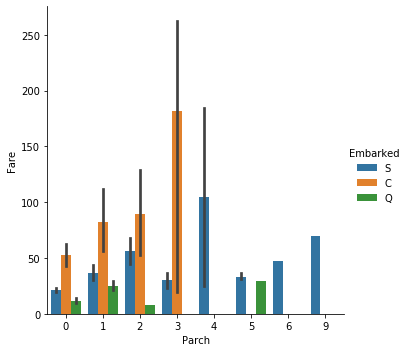

In [23]:
g = sns.factorplot(y='Fare',x='Parch',hue='Embarked',data=dataset,kind='bar')

as we can see from the graph above, when fare is around $80 and Parch = 1,it is more likely for Embarked to be 'C', so lets fill in the missing value as 'C'

In [24]:
dataset["Embarked"].fillna('C', inplace = True)
dataset.isnull().any()

Age             True
Cabin           True
Embarked       False
Fare            True
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived        True
Ticket         False
dtype: bool

**1.2 Age**

In [25]:
dataset.Age.isnull().sum()

263

replace missing value using median

In [26]:
dataset['Age'].fillna(dataset['Age'].median(),inplace=True)
dataset.isnull().any()

Age            False
Cabin           True
Embarked       False
Fare            True
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived        True
Ticket         False
dtype: bool

**2. Convert catogrical data**

**2.1 Sex**

In [27]:
dataset['Sex']=dataset['Sex'].map({'male':0,'female':1}).astype(int)
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450


**2.2 Embarked**

In [28]:
dataset['Embarked']=dataset['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171
1,38.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599
2,26.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282
3,35.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803
4,35.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450


**3 Adding feature**

**3.1 Create new feature combining Sibsp and Parch**

In [29]:
dataset['Group']=dataset['SibSp']+ dataset['Parch']+1
dataset[['Group','Survived']].groupby(['Group']).mean().reset_index(drop=False)

,Group,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


**3.2 Age: create the Age bands**

- Age is a continous feature, there is a problem with Continous Variables in Machine Learning Models
- We need to convert these continous values into categorical values by either Binning or Normalisation. 
- I will be using binning i.e group a range of ages into a single bin or assign them a single value. As the maximum age of a passenger was 80. So lets divide the range from 0-80 into 5 bins

In [30]:
dataset['Age_bands']=pd.cut(dataset['Age'],5)
dataset.head()
dataset[['Age_bands','Survived']].groupby('Age_bands').mean().reset_index(drop=False)

,Age_bands,Survived
0,"(0.0902, 16.136]",0.550000
1,"(16.136, 32.102]",0.344168
2,"(32.102, 48.068]",0.404255
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [31]:
dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
dataset.loc[ dataset['Age'] > 64, 'Age']
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Group,Age_bands
0,1.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,2,"(16.136, 32.102]"
1,2.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,2,"(32.102, 48.068]"
2,1.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,1,"(16.136, 32.102]"
3,2.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,2,"(32.102, 48.068]"
4,2.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,1,"(32.102, 48.068]"


**4. drop Feature**

In [32]:
dataset1=dataset.drop(['Cabin','Fare','Name','PassengerId','Parch','SibSp','Ticket','Age_bands'],axis=1)
dataset1.head()
dataset1.isnull().sum()

Age           0
Embarked      0
Pclass        0
Sex           0
Survived    418
Group         0
dtype: int64

# Decision Tree Model 

In [33]:
# Split the data to train and test 
train = dataset1[:train_len]
test = dataset1[train_len:]

xtrain= train.drop('Survived',axis=1)
ytrain= train[['Survived']]
xtest= test.drop('Survived',axis=1)

**Gini Impurity**

In [34]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [35]:
train['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

First, we need to calculate the Gini Impurity of the starting node. We have 891 observations in train dataset and only 342 observations survived, the survival probability is around 38.38% (342/891)

In [36]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

We're now going to simulate both splits, calculate the impurity of resulting nodes and then obtain the weighted Gini Impurity after the split to measure how much each split has actually reduced impurity.

If we split by Sex, we'll have the two following nodes:

Node with men: 577 observations with only 109 survived
Node with women: 314 observations with 233 survived

In [37]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [38]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [39]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

**Finding best tree depth with the help of Cross Validation**

In [40]:
# Desired number of Cross Validation folds
cv = KFold(n_splits=6)           
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

In [41]:
# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.786716
         2          0.775531
         3          0.811423
         4          0.821520
         5          0.806941
         6          0.803563


The best max_depth parameter seems therefore to be 4 (82% average accuracy across the 6 folds), and feeding the model with more data results in worst results probably due to over-fitting. We'll therefore use 4 as the max_depth parameter for our final model.

**Final Tree**

In [42]:
# Create Decision Tree with max_depth = 4
decision_tree = tree.DecisionTreeClassifier(max_depth = 4)
# train decision tree classifer
decision_tree.fit(xtrain, ytrain)
#predict the response for test dataset
ypred = decision_tree.predict(xtest)

In [43]:
print('Accuracy:',decision_tree.score(xtrain, ytrain) * 100)

Accuracy: 82.49158249158249


In [44]:
#Feature Importances
features = list(xtrain.columns)
fi = pd.DataFrame({'feature': features,
                   'importance': decision_tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
3,Sex,0.624599
2,Pclass,0.206728
4,Group,0.095933
0,Age,0.056912
1,Embarked,0.015829


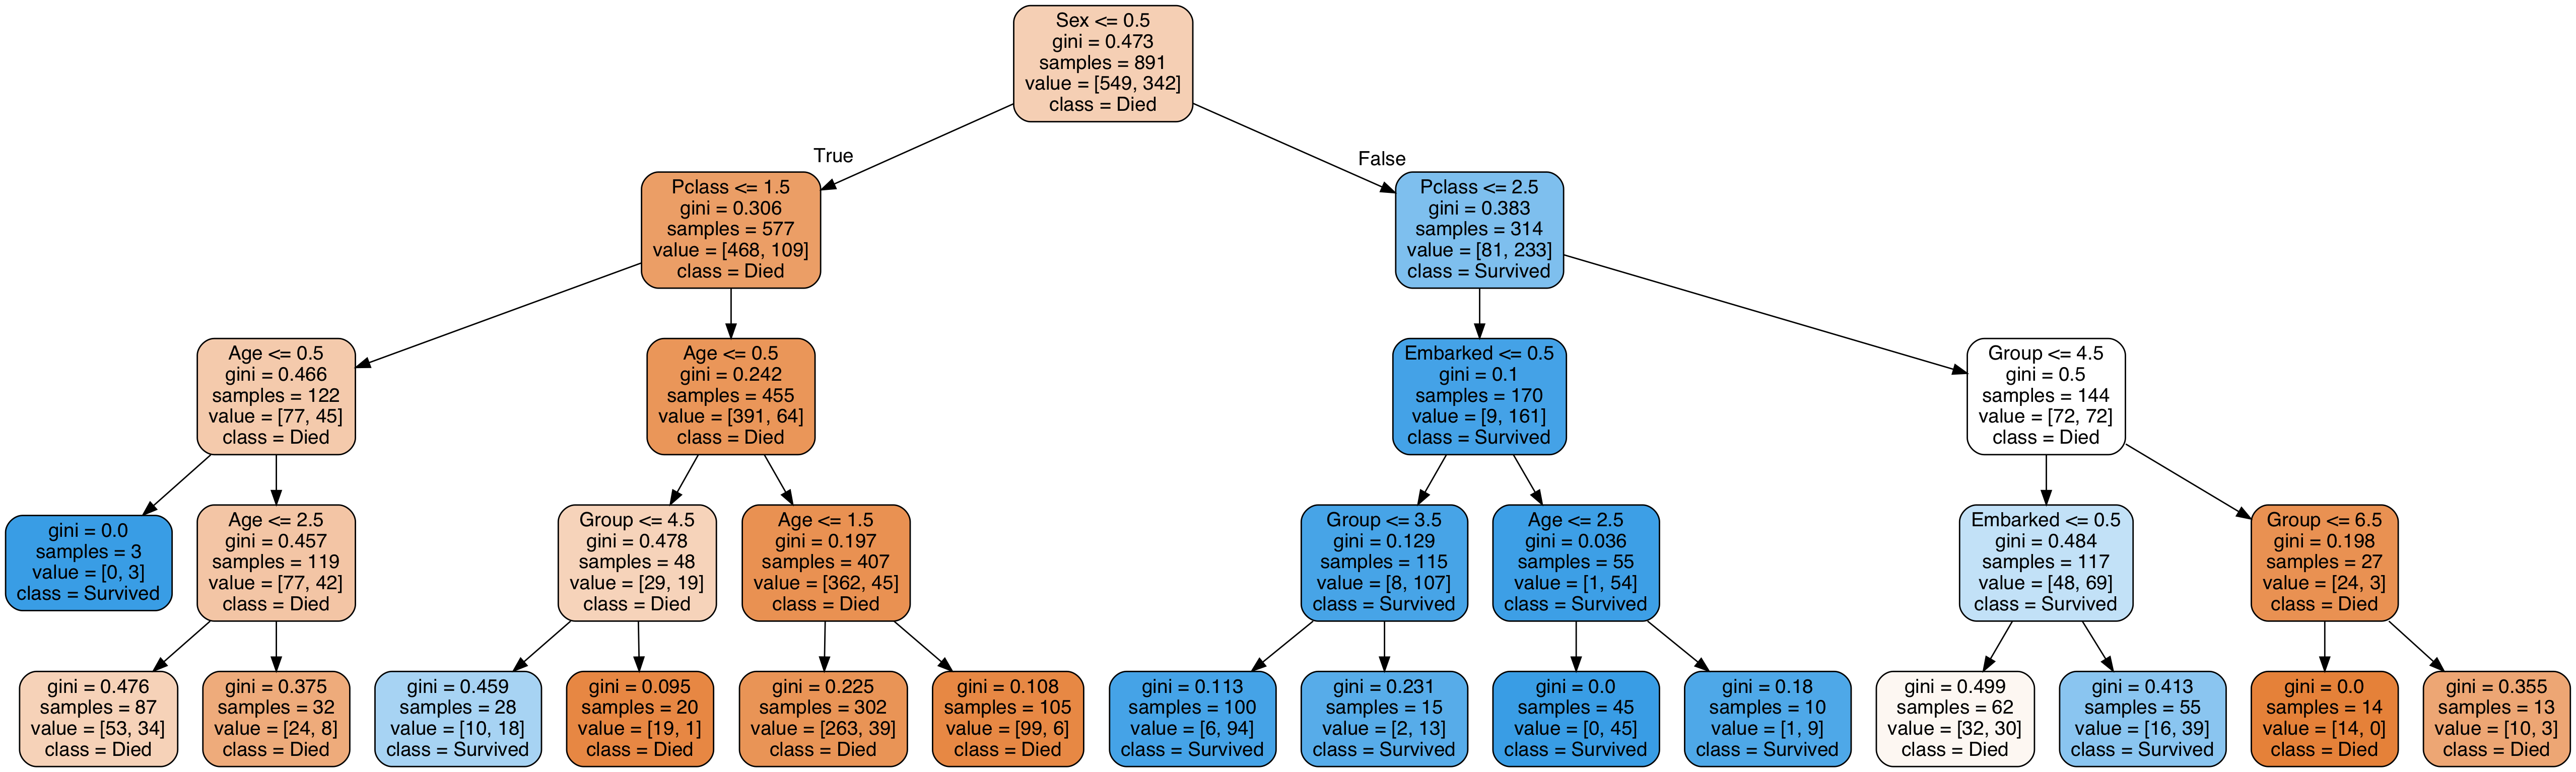

In [45]:
#Visualize Full Tree
# Save tree as dot file
export_graphviz(decision_tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features,
                class_names = ['Died', 'Survived'], filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

# Visualize
Image(filename='tree_real_data.png')